# Deep Learning: Mastering Neural Networks - Module 5 Assignment: LSTM Sentence Completion

Now that we have a framework for working with sequential data in PyTorch - we would like to improve our sentence completion model by introducing a more sophisticated dataset encoding and neural network architecture.

In this assignment, we would like you to implement an LSTM model that contains 2 hidden layers and completes sentences at a word level encoding instead of character. We will provide code for cleaning and preparing the data as well as some helper functions so that you can complete the task.

Note: This LSTM can take a long time to train. Try using a small number of epochs or a small dataset(~10 samples) to verify your network can train properly before using the full dataset and a larger number of Epochs!

## Dataset and Encoding

We will use the same dataset as the last notebook, however we will now use the spanish sentences as the targets for our sequence!

In [64]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
# Here we download and unzip the text file that contains all of our translated phrases
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

--2025-07-27 03:12:51--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5453910 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.20M  2.49MB/s    in 2.1s    

2025-07-27 03:12:54 (2.49 MB/s) - ‘spa-eng.zip’ saved [5453910/5453910]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


In [25]:
# Helper functions combined from PyTorch tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
# This is important because we want all words to be formatted the same similar
# to our image normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Read the file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Throw out the attribution as it is not a part of the data
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [26]:
pairs = parse_data("spa.txt")
# We only want the english sentences because we aren't translating
english_sentences = [pair[0] for pair in pairs]
# Shuffle our dataset
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 142511


In [27]:
# Since we already shuffled our dataset, grab a random sampling of sentences for our train, val, and test
# Here we are using a small number of Sentences to ease training time. Feel free to use more
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

# Using this function we will create a dictionary to use for our one hot encoding vectors
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)



In [28]:
print(len(english_dictionary))

2748


In [29]:
print(len(english_list))

2748


### Encoding

We will encode our sequences in a very similar format to the previous tasks. However, our one-hot encoding vectors will encode over a dictionary of words instead of specific characters. This will result in a larger one hot encoding vector but a shorter overall sequence length for each sentence.

In [44]:
# Now make our training samples:
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        if word not in word_dictionary:
            print("Error: This word is not in our dataset - using a zeros tensor")
            continue
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor


train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

In [45]:
def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

print("This code helps visualize which words represent an input_tensor and its corresponding target_tensor!")
examples_to_show = 6
count = 1
for input, target in train_tensors:
    print(tensor_to_sentence(english_list, input))
    print(tensor_to_sentence(english_list, target))
    count +=1
    if count > examples_to_show:
        break


This code helps visualize which words represent an input_tensor and its corresponding target_tensor!
he's getting along well with all of his classmates 
getting along well with all of his classmates <EOS>
you could have omitted that last phrase in your letter 
could have omitted that last phrase in your letter <EOS>
he finished school in march 
finished school in march <EOS>
please forgive me for not having written sooner 
forgive me for not having written sooner <EOS>
he married my cousin 
married my cousin <EOS>
have you ever sewed on a button 
you ever sewed on a button <EOS>


In [46]:
# Let's look at a few sentence encodings, to see what those look like:
for i in range(6):
    print(train_sentences[i], "[encode as]", train_tensors[i][0])

he's getting along well with all of his classmates [encode as] tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
you could have omitted that last phrase in your letter [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
he finished school in march [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
please forgive me for not having written sooner [encode as] tensor([[[0

In [47]:
dataloaders = {'train': train_tensors,
               'val': val_tensors,
               'test': test_tensors}

dataset_sizes = {'train': len(train_tensors),
                 'val': len(val_tensors),
                 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### LSTM Definition

Fill in your model in this section - a skeleton has been provided!


In [107]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        # TODO
        ## I've referenced these documents:
        ## 1. https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        ## 2. https://docs.pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        ## 3. https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, dropout=0.05)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # TODO
        output, hidden = self.lstm(input, hidden)
        output = self.fc(output)
        return output, hidden

    def initHidden(self):
        # We need two hidden layers because of our two layered lstm!
        # Your model should be able to use this implementation of initHidden()
        return (torch.zeros(2, self.hidden_size).to(device), torch.zeros(2, self.hidden_size).to(device))

In [101]:
# TODO
num_words = len(english_list) + 1 # Need to add 1 for the End Tag
lstm = LSTM(num_words, 128, num_words).to(device)

In [102]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for input_sequence, target_sequence in dataloaders[phase]:
                # Now Iterate through each sequence here:

                hidden = model.initHidden() # Start with a fresh hidden state

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Make a prediction for each element in the sequence,
                    # keeping track of the hidden state along the way
                    for i in range(current_input_sequence.size(0)):
                        # Need to be clever with how we transfer our hidden layers to the device
                        current_hidden = (hidden[0].to(device), hidden[1].to(device))
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # backward + update weights only if in training phase at the end of a sequence
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            # Note: We are using the train loss here to determine our best model
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [103]:
# We define our predict function here so that we can run some predictions in the same cell as our training!
def predict(model, word_dictionary, word_list, input_sentence, max_length = 20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi ==  len(word_dictionary):
        topv, topi = output.topk(2)
        topi = topi[0][1]
    word = word_list[topi]
    output_sentence += word
    output_sentence += " "
    input = create_input_tensor(word, word_dictionary)

    for i in range(len(input_sentence.split(" ")), max_length):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == len(word_dictionary):
            # print("Hit the EOS")
            break
        word = word_list[topi]
        output_sentence += word
        output_sentence += " "
        input = create_input_tensor(word, word_dictionary)
    return output_sentence

In [104]:
# TODO: Fill in the necessary code to execute the training function
"""
Your Code Below:
"""

learning_rate = 0.001
num_epochs = 10
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)



lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

print(predict(lstm, english_dictionary, english_list, "what is"))
print(predict(lstm, english_dictionary, english_list, "my name"))
print(predict(lstm, english_dictionary, english_list, "how are"))
print(predict(lstm, english_dictionary, english_list, "hi"))
print(predict(lstm, english_dictionary, english_list, "choose"))


Epoch 1/10
----------
train Loss: 5.9372
val   Loss: 5.7093
test  Loss: 5.6892

Epoch 2/10
----------
train Loss: 5.4171
val   Loss: 5.6688
test  Loss: 5.6570

Epoch 3/10
----------
train Loss: 5.1567
val   Loss: 5.6892
test  Loss: 5.6840

Epoch 4/10
----------
train Loss: 4.9041
val   Loss: 5.6764
test  Loss: 5.6746

Epoch 5/10
----------
train Loss: 4.6453
val   Loss: 5.6662
test  Loss: 5.6616

Epoch 6/10
----------
train Loss: 4.3968
val   Loss: 5.6790
test  Loss: 5.6697

Epoch 7/10
----------
train Loss: 4.1804
val   Loss: 5.8009
test  Loss: 5.7858

Epoch 8/10
----------
train Loss: 3.9918
val   Loss: 5.8497
test  Loss: 5.8297

Epoch 9/10
----------
train Loss: 3.8258
val   Loss: 5.9043
test  Loss: 5.8854

Epoch 10/10
----------
train Loss: 3.6744
val   Loss: 5.8407
test  Loss: 5.8253

Training complete in 2m 46s
Best val Loss: 3.674406 at epoch 9
what is the book 
my name is is the world 
how are the book and saw to understand 
hi is the second person 
choose is the second person

### Visualizing Results

Take a look at the training curves - does your model overfit to your training data? If so, why do you think that may be? Enter your explanation in the cell below.

TODO: Your answer here.

1. Model without dropout and regularization:

There are obvious overfit, the val-loss and test-loss curves increase quickly with the train-loss decrease.

2. Model with `dropout=0.05` and `weight_decay=0.001`:

There are still overfit, but it's better.

I think there are some reasons:

- The train set is not large enough, also the dataset doesn't have too much diverse.

- We always choose the top1, so it may not so good.

- One-hot encoding can't express the word meanings internally, actually words are related to each other, but one-hot is orthogonal.


In [105]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

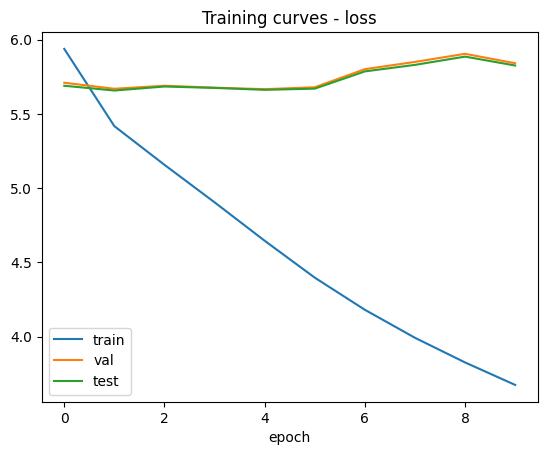

In [106]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])